In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nolearn.lasagne import visualize
%matplotlib inline

ERROR (theano.sandbox.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\theano\sandbox\gpuarray\__init__.py", line 95, in <module>
    init_dev(config.device)
  File "C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\theano\sandbox\gpuarray\__init__.py", line 46, in init_dev
    "Make sure Theano and libgpuarray/pygpu "
RuntimeError: ('Wrong major API version for gpuarray:', 1, 'Make sure Theano and libgpuarray/pygpu are in sync.')
C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

################################################################################
def plot_image(pixels, label, color="gray"):
    """
        Plot a image in 28x28pixels
    """
    pixels = pixels.reshape((28, 28))
    
    # Plot
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap=color, interpolation=None)
    plt.show()
    
################################################################################
from sklearn.metrics import confusion_matrix, classification_report
import itertools

def plot_matrix(clf, X_test, y_test):
    plt.clf()
    cm = confusion_matrix(y_test,clf.predict(X_test))

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    cm_normalized[np.isnan(cm_normalized)] = 0.0
    #print(cm_normalized)
    plt.tick_params(labelsize=10)

    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm_normalized[i, j],2),horizontalalignment="center")    
    plt.colorbar()
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

### Split Data

In [3]:
X_train, labels = load_mnist('data/fashion', kind='train')
#X_test, y_test = load_mnist('/home/l34n/Downloads/fashion', kind='t10k')

### Plot an example - Without pre-processing

In [4]:
label = labels[0]
pixels = X_train[0]

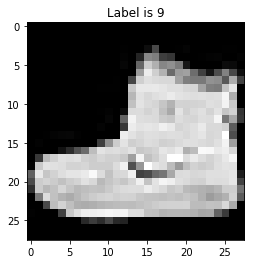

In [5]:
plot_image(pixels, label)

### Plot an example -  With pre-processing

In [6]:
from sklearn.preprocessing import Normalizer, MinMaxScaler

In [7]:
xs = MinMaxScaler([0, 1]).fit_transform(X_train)
#xs = Normalizer().fit_transform(X_train)

C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
label = labels[0]
pixels = xs[0]

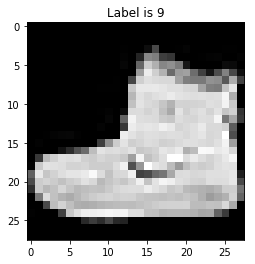

In [9]:
plot_image(pixels, label)

In [10]:
import lasagne

In [11]:
import theano
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import BatchIterator
from nolearn.lasagne import NeuralNet
from lasagne.layers import InputLayer, Conv2DLayer, DropoutLayer,\
    MaxPool2DLayer, DenseLayer, FlattenLayer
from lasagne.nonlinearities import softmax

### Definición de RED

In [12]:
## The minimal architecture ... ~0.74
layers_1 = [
            (InputLayer, {'shape': (None, 784)}),
            (DenseLayer, {'num_units': 1024}),
            (DropoutLayer, {'p': 0.5}),
            #(DenseLayer, {'num_units': 1024}),
            #(DenseLayer, {'num_units': 1024}),
            (DenseLayer, {'num_units': 2014}),
            (DropoutLayer, {'p': 0.5}),
            # Se suponen que son los valores del label a predecir.
            (DenseLayer, {'num_units': 10, 'nonlinearity': softmax}),
    ]

In [13]:
layers_2 = [
            (InputLayer, {'shape': (None, 1, 28, 28)}),
            (Conv2DLayer, {'num_filters': 8, 'filter_size': 3, 'W': lasagne.init.GlorotUniform()}),
            (MaxPool2DLayer, {'pool_size': 2}),
            # (DropoutLayer, {'p': 0.5}),
            (Conv2DLayer, {'num_filters': 8, 'filter_size': 3, 'W': lasagne.init.GlorotUniform()}),
            (MaxPool2DLayer, {'pool_size': 2}),
            (DenseLayer, {'num_units': 100, 'nonlinearity': lasagne.nonlinearities.rectify}),
            (DropoutLayer, {'p': 0.5}),
            # Se suponen que son los valores del label a predecir.
            (DenseLayer, {'num_units': 10, 'nonlinearity': softmax}),
    ]

In [14]:
layers_3 = [
                (InputLayer, {'shape': (None, 1, 28, 28)}), #cantidad, canal(monocromatico),col,filas
                (Conv2DLayer, {'num_filters':10, 'filter_size': 3, 'W': lasagne.init.GlorotUniform()}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (Conv2DLayer, {'num_filters':5, 'filter_size': 2, 'W': lasagne.init.GlorotUniform()}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (DenseLayer, {'num_units': 1000, 'nonlinearity': lasagne.nonlinearities.rectify}),
                (DropoutLayer, {'p': 0.5}),
                (DenseLayer, {'num_units': 10, 'nonlinearity': lasagne.nonlinearities.softmax}),
]

In [15]:
### Arquitectura de Damian
layer_d = [(InputLayer, {'shape': (None, 1, 28, 28)}), #cantidad, canal(monocromatico),col,filas
                (Conv2DLayer, {'num_filters':10, 'filter_size': 5, 'W': lasagne.init.GlorotUniform()}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (Conv2DLayer, {'num_filters':5, 'filter_size': 3, 'W': lasagne.init.GlorotUniform()}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (Conv2DLayer, {'num_filters':5, 'filter_size': 2, 'W': lasagne.init.GlorotUniform()}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (DenseLayer, {'num_units': 100, 'nonlinearity': lasagne.nonlinearities.rectify}),
                (DropoutLayer, {'p': 0.5}),
                (DenseLayer, {'num_units': 10, 'nonlinearity': lasagne.nonlinearities.softmax}),
          ]

In [16]:
## The MNIS architecture ... ~0.85
layers_4 = [
                (InputLayer, {'shape': (None, 1, 28, 28)}), #cantidad, canal(monocromatico),col,filas
                (Conv2DLayer, {'num_filters':6, 'filter_size': 5, 'W': lasagne.init.GlorotUniform()}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (Conv2DLayer, {'num_filters':10, 'filter_size': 5, 'W': lasagne.init.GlorotUniform()}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (DenseLayer, {'num_units': 100, 'nonlinearity': lasagne.nonlinearities.rectify}),
                (DropoutLayer, {'p': 0.5}),
                (DenseLayer, {'num_units': 10, 'nonlinearity': lasagne.nonlinearities.softmax}),
]

In [17]:
layers_0 = [
                (InputLayer, {'shape': (None, 1, 28, 28)}), #cantidad, canal(monocromatico),col,filas
                
                (Conv2DLayer, {'num_filters':32, 'filter_size': 3, 'W': lasagne.init.GlorotUniform(), 
                              'nonlinearity': lasagne.nonlinearities.rectify}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (DropoutLayer, {'p': 0.25}),
                
                (Conv2DLayer, {'num_filters':64, 'filter_size': 3, 'W': lasagne.init.GlorotUniform(),
                              'nonlinearity': lasagne.nonlinearities.rectify}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (DropoutLayer, {'p': 0.25}),
                
                (Conv2DLayer, {'num_filters':128, 'filter_size': 3, 'W': lasagne.init.GlorotUniform(),
                              'nonlinearity': lasagne.nonlinearities.rectify}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (DropoutLayer, {'p': 0.4}),
                
                #(FlattenLayer,{}),
                (DenseLayer, {'num_units': 128, 'nonlinearity': lasagne.nonlinearities.rectify}),
                (DropoutLayer, {'p': 0.3}),
                (DenseLayer, {'num_units': 128, 'nonlinearity': lasagne.nonlinearities.rectify}),
                
                (DenseLayer, {'num_units': 10, 'nonlinearity': lasagne.nonlinearities.softmax}),
]

In [18]:
##Celia's architecture
layers_5 = [
                (InputLayer, {'shape': (None, 1, 28, 28)}), #cantidad, canal(monocromatico),col,filas
                
                (Conv2DLayer, {'num_filters':30, 'filter_size': 5, 'W': lasagne.init.GlorotUniform()}),
                (MaxPool2DLayer, {'pool_size': 2}), #tenia 20 filtros
                
                (Conv2DLayer, {'num_filters':10, 'filter_size': 4, 'W': lasagne.init.GlorotUniform()}),
                (MaxPool2DLayer, {'pool_size': 2}), #tenia 8 filtros
                
                #(Conv2DLayer, {'num_filters':3, 'filter_size': 3, 'W': lasagne.init.GlorotUniform()}),
                #(MaxPool2DLayer, {'pool_size': 2}),
    
                #(Conv2DLayer, {'num_filters':10, 'filter_size': 2, 'W': lasagne.init.GlorotUniform()}),
                #(MaxPool2DLayer, {'pool_size': 2}),
    
                (DenseLayer, {'num_units': 50}),
                (DropoutLayer, {'p':0.25}),
                (DenseLayer, {'num_units': 10}),
                
                (DenseLayer, {'num_units': 10, 'nonlinearity': lasagne.nonlinearities.softmax}),
]

In [19]:
class AdjustVariable(object):
    """
    Used to decreases linearly the learning rate with the number of epochs,
    while we the momentum increase.
    """
    def __init__(self, name, start=0.01, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = np.float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

In [20]:
def create_network(npochs=5, batch_s=10000):
    return NeuralNet(
        layers=layers_5,
        update=nesterov_momentum,
        update_learning_rate=theano.shared(np.float32(0.01)),
        update_momentum=theano.shared(np.float32(0.9)),

        regression=False,
        batch_iterator_train=BatchIterator(batch_size=batch_s),
        on_epoch_finished=[
            AdjustVariable('update_learning_rate', start=0.1, stop=0.01),
            AdjustVariable('update_momentum', start=0.9, stop=0.9999)
        ],
        max_epochs=npochs,
        verbose=1)

In [21]:
from sklearn.model_selection import train_test_split

net0 = create_network(1000,2500) #npochs, batch_size

xs = xs.reshape(-1, 1, 28, 28)

X_train, X_test, y_train, y_test = train_test_split(xs, labels, random_state=42)

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int32)

In [22]:
from timeit import default_timer as timer
comienzo = timer()


In [23]:
net0.fit(X_train, y_train)


# Neural Network with 14260 learnable parameters

## Layer information

  #  name        size
---  ----------  --------
  0  input0      1x28x28
  1  conv2d1     30x24x24
  2  maxpool2d2  30x12x12
  3  conv2d3     10x9x9
  4  maxpool2d4  10x4x4
  5  dense5      50
  6  dropout6    50
  7  dense7      10
  8  dense8      10

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  ------
      1     2.29244     2.27545    1.00746      0.19527  40.44s
      2     2.15140     1.61238    1.33430      0.43008  40.35s
      3     1.69256     0.99883    1.69454      0.60324  40.55s
      4     0.98241     0.71336    1.37715      0.71909  40.54s
      5     0.76169     0.62152    1.22552      0.75508  40.51s
      6     0.68107     0.57871    1.17687      0.77296  40.55s
      7     0.63780     0.54982    1.16002      0.78596  40.88s
      8     0.60733     0.52727    1.15184      0.79729  40.52s
      9     0.58095     0.52417    1.

    109     0.24315     0.31966    0.76063      0.89192  40.61s
    110     0.24623     0.31155    0.79034      0.89270  40.90s
    111     0.24116     0.32982    0.73117      0.89126  40.58s
    112     0.24709     0.31371    0.78764      0.89304  40.78s
    113     0.24869     0.31134    0.79877      0.89481  40.58s
    114     0.23995     0.31506    0.76159      0.89237  40.67s
    115     0.23622     0.31613    0.74722      0.89392  40.83s
    116     0.25243     0.32274    0.78213      0.89204  40.57s
    117     0.23698     0.33078    0.71643      0.89181  40.75s
    118     0.23782     0.32874    0.72344      0.88981  40.94s
    119     0.23686     0.32684    0.72471      0.88715  40.68s
    120     0.23796     0.32846    0.72447      0.89037  40.72s
    121     0.23797     0.32958    0.72203      0.89492  40.52s
    122     0.23866     0.31844    0.74946      0.89559  40.55s
    123     0.23667     0.32898    0.71941      0.89348  40.51s
    124     0.23963     0.32328    0.741

    233     0.18406     0.39107    0.47065      0.88859  40.90s
    234     0.17826     0.41514    0.42940      0.88815  40.82s
    235     0.19406     0.38451    0.50470      0.89037  41.10s
    236     0.18319     0.38732    0.47296      0.89048  41.39s
    237     0.18267     0.38844    0.47026      0.88915  40.93s
    238     0.18242     0.39374    0.46331      0.88870  40.91s
    239     0.17829     0.38861    0.45878      0.88837  41.09s
    240     0.17810     0.40451    0.44028      0.88770  40.62s
    241     0.18496     0.39361    0.46990      0.89148  40.80s
    242     0.18281     0.39520    0.46256      0.89192  41.04s
    243     0.18067     0.40639    0.44458      0.88659  40.88s
    244     0.18494     0.39857    0.46402      0.88770  40.87s
    245     0.18144     0.39761    0.45633      0.88904  40.86s
    246     0.17964     0.39613    0.45349      0.88715  40.75s
    247     0.17939     0.39557    0.45349      0.88515  40.85s
    248     0.17507     0.43156    0.405

    359     0.15711     0.45096    0.34838      0.88593  41.29s
    360     0.15879     0.43961    0.36120      0.88904  41.75s
    361     0.15297     0.45876    0.33344      0.88870  41.08s
    362     0.15421     0.46088    0.33460      0.88904  41.28s
    363     0.15159     0.46321    0.32727      0.88604  41.28s
    364     0.14805     0.45204    0.32751      0.88659  41.06s
    365     0.15426     0.47129    0.32731      0.88804  40.88s
    366     0.15170     0.46528    0.32604      0.88804  41.13s
    367     0.14546     0.45239    0.32154      0.88959  40.68s
    368     0.14603     0.45418    0.32153      0.88637  41.16s
    369     0.15540     0.44972    0.34555      0.88837  41.17s
    370     0.14864     0.46176    0.32190      0.88637  40.91s
    371     0.14742     0.46038    0.32021      0.88993  40.96s
    372     0.15270     0.45583    0.33499      0.88693  40.76s
    373     0.14631     0.47489    0.30808      0.88770  41.06s
    374     0.15214     0.46199    0.329

    485     0.13424     0.53440    0.25119      0.88459  41.15s
    486     0.13337     0.54875    0.24305      0.88559  41.19s
    487     0.12948     0.55174    0.23467      0.88682  41.36s
    488     0.13602     0.53965    0.25206      0.88437  41.45s
    489     0.13195     0.54053    0.24412      0.88704  41.19s
    490     0.12927     0.56327    0.22950      0.88482  41.20s
    491     0.13157     0.53810    0.24451      0.88315  41.40s
    492     0.12695     0.55535    0.22859      0.88626  41.00s
    493     0.13320     0.53746    0.24784      0.88759  41.55s
    494     0.12847     0.55467    0.23161      0.88482  41.18s
    495     0.13536     0.53947    0.25091      0.88504  41.37s
    496     0.13299     0.53243    0.24979      0.88259  41.22s
    497     0.13165     0.54834    0.24009      0.88693  41.45s
    498     0.13258     0.52703    0.25157      0.88515  41.35s
    499     0.13274     0.55949    0.23726      0.88504  41.72s
    500     0.12672     0.55088    0.230

    612     0.12067     0.59187    0.20389      0.88382  41.90s
    613     0.12178     0.59613    0.20428      0.88437  41.95s
    614     0.12263     0.58640    0.20913      0.88371  41.81s
    615     0.12221     0.59549    0.20523      0.88482  41.53s
    616     0.12452     0.58740    0.21199      0.88282  41.75s
    617     0.12440     0.58332    0.21326      0.88060  41.85s
    618     0.12603     0.60313    0.20897      0.88182  41.79s
    619     0.12573     0.58897    0.21348      0.88282  41.35s
    620     0.12384     0.60920    0.20329      0.88171  41.97s
    621     0.12619     0.60174    0.20970      0.88515  41.77s
    622     0.12475     0.57857    0.21562      0.88437  41.55s
    623     0.12231     0.58169    0.21026      0.88326  41.54s
    624     0.12481     0.58467    0.21348      0.88248  41.76s
    625     0.12304     0.56914    0.21619      0.88271  41.40s
    626     0.12639     0.58421    0.21635      0.88004  43.05s
    627     0.12424     0.59738    0.207

    739     0.11770     0.65935    0.17851      0.88782  41.84s
    740     0.11913     0.63633    0.18721      0.88648  41.92s
    741     0.11525     0.66649    0.17292      0.88881  41.97s
    742     0.11272     0.66929    0.16842      0.88759  41.69s
    743     0.11761     0.68284    0.17224      0.88559  41.77s
    744     0.11248     0.70189    0.16025      0.88448  41.64s
    745     0.11459     0.68174    0.16809      0.88515  41.98s
    746     0.11463     0.66830    0.17153      0.87982  41.54s
    747     0.11651     0.66110    0.17623      0.88293  41.83s
    748     0.11597     0.65365    0.17742      0.88793  41.76s
    749     0.11263     0.68129    0.16533      0.88848  41.78s
    750     0.11380     0.68658    0.16575      0.88615  41.82s
    751     0.11665     0.67131    0.17377      0.88637  41.88s
    752     0.11369     0.68086    0.16697      0.88471  43.27s
    753     0.11608     0.67091    0.17301      0.88570  41.99s
    754     0.11559     0.66903    0.172

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x000000000B1AA400>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x000000000B38D9B0>,
     check_input=True, custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 28, 28)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 5, 'W': <lasagne.init.GlorotUniform object at 0x000000000B852198>, 'num_filters': 30}), (<class 'lasagne.layers.pool.MaxPool2DLayer'>, {'pool_size': 2}), (<c...rs.dense.DenseLayer'>, {'num_units': 10, 'nonlinearity': <function softmax at 0x000000000AC1EB38>})],
     loss=None, max_epochs=1000, more_params={},
     objective=<function objective at 0x000000000B1ACC18>,
     objective_loss_function=<function categorical_crossentropy at 0x000000000AF3C668>,
     on_batch_finished=[],
     on_epoch_finished=[<__main__.AdjustVariable object at 0x000000000B5FA0F0>, <__main__.AdjustVariable obje

In [24]:
fin = timer() - comienzo
print("Tiempo red neuronal convulcionada:",fin, " sg ")

('Tiempo red neuronal convulcionada:', 33286.352852932476, ' sg ')


### Validación de Red

In [25]:
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.int32)

In [26]:
CLASSES = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

classes = [x for x in CLASSES.values()]

print(classification_report(y_test, net0.predict(X_test), target_names=classes))

             precision    recall  f1-score   support

T-shirt/top       0.77      0.86      0.81      1486
    Trouser       0.99      0.97      0.98      1546
   Pullover       0.82      0.83      0.82      1499
      Dress       0.89      0.88      0.88      1484
       Coat       0.80      0.83      0.82      1515
     Sandal       0.96      0.97      0.96      1493
      Shirt       0.72      0.62      0.66      1505
    Sneaker       0.94      0.93      0.94      1476
        Bag       0.96      0.96      0.96      1500
 Ankle boot       0.95      0.96      0.96      1496

avg / total       0.88      0.88      0.88     15000



Normalized confusion matrix


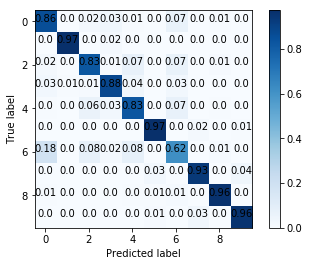

In [27]:
plot_matrix(net0, X_test, y_test)

<module 'matplotlib.pyplot' from 'C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\matplotlib\pyplot.pyc'>

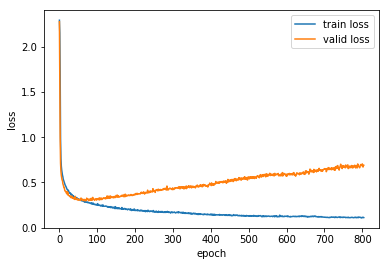

In [28]:
visualize.plot_loss(net0)

C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<module 'matplotlib.pyplot' from 'C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\matplotlib\pyplot.pyc'>

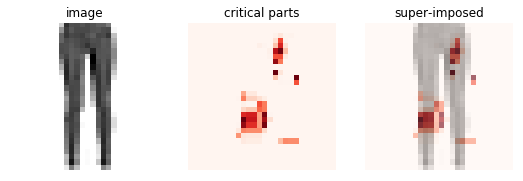

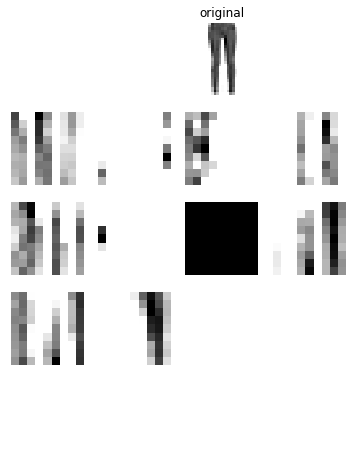

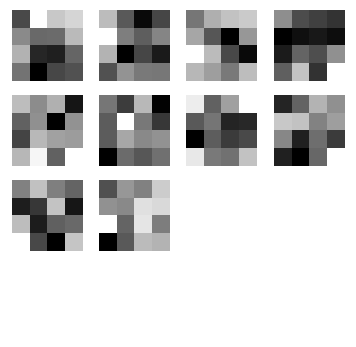

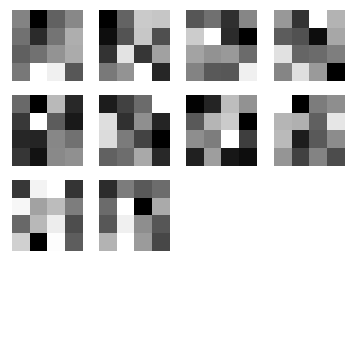

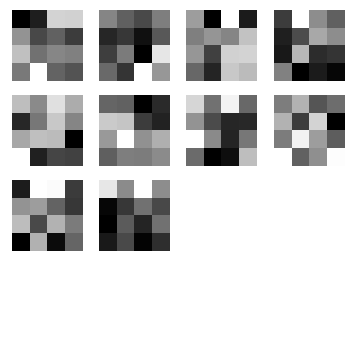

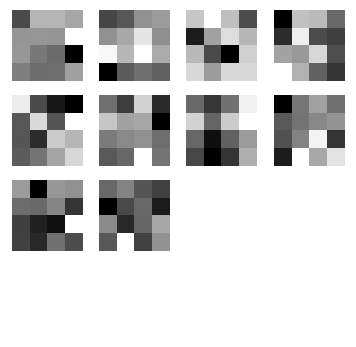

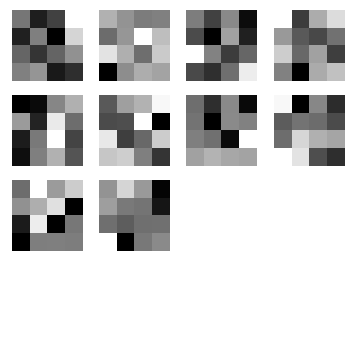

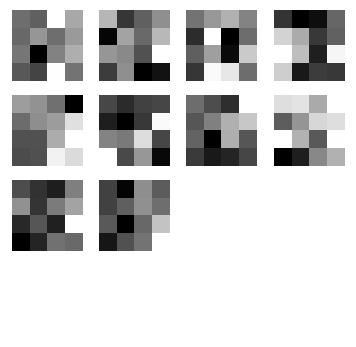

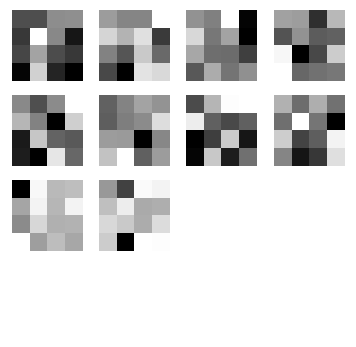

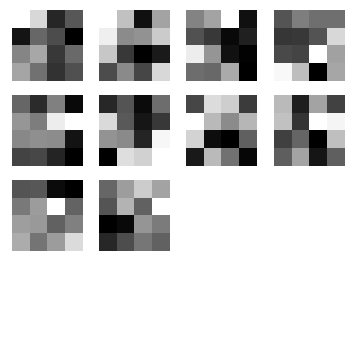

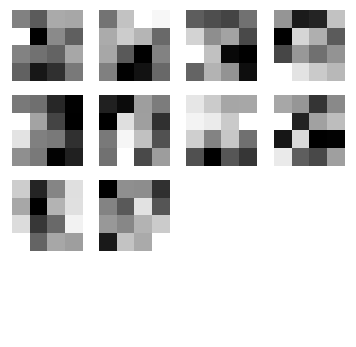

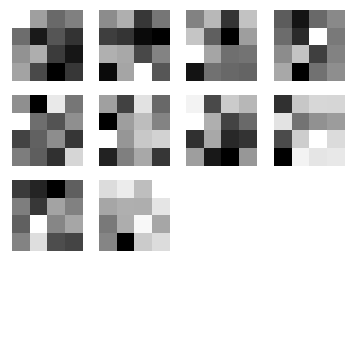

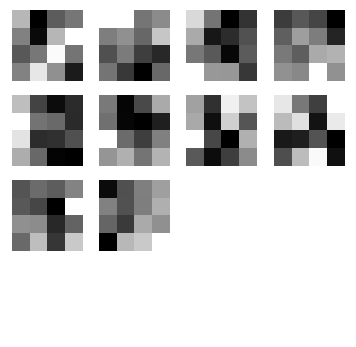

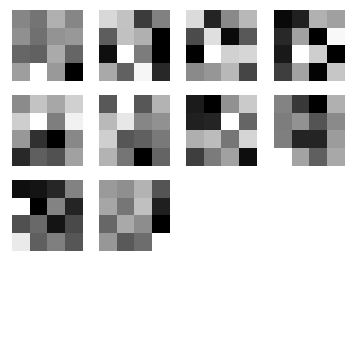

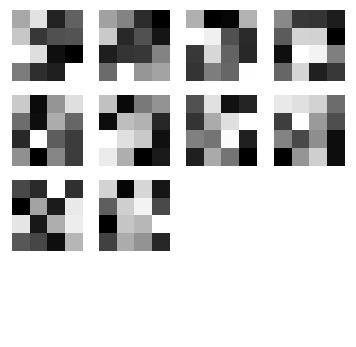

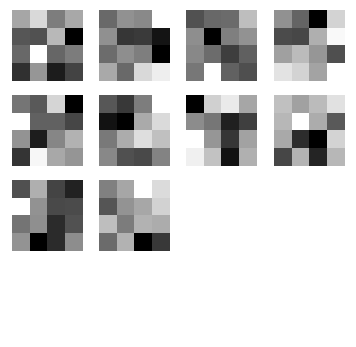

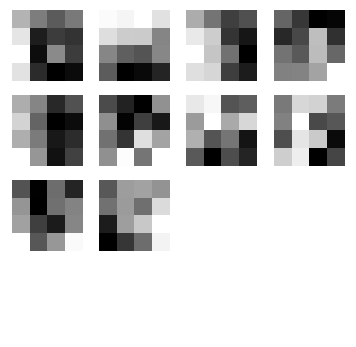

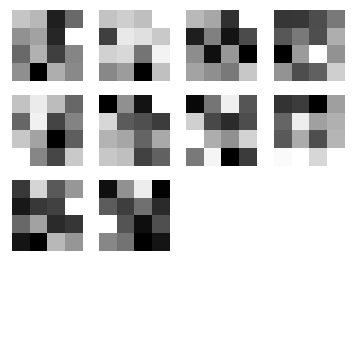

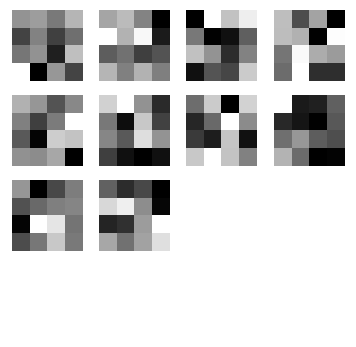

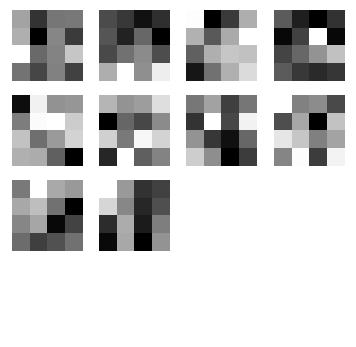

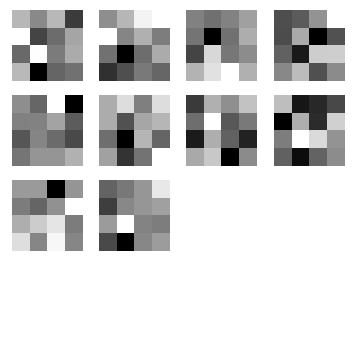

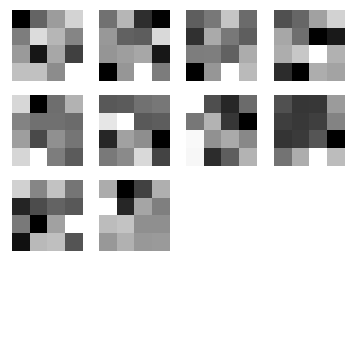

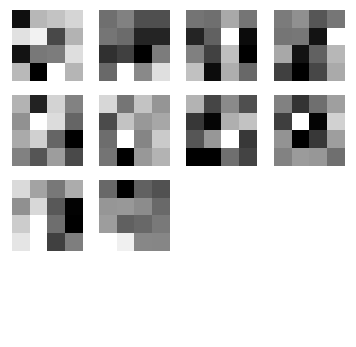

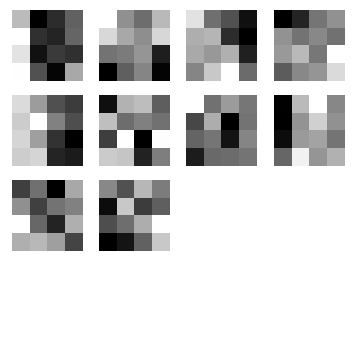

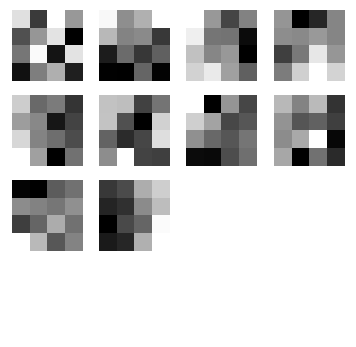

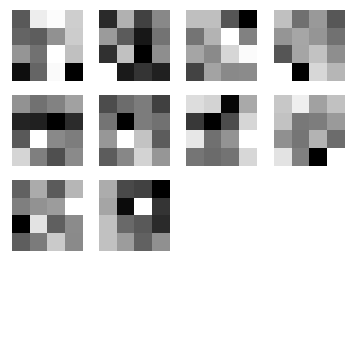

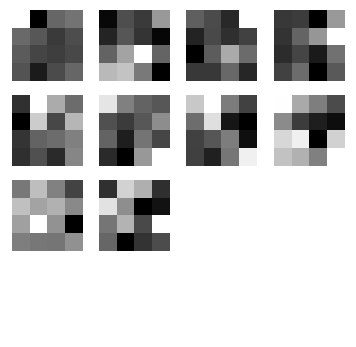

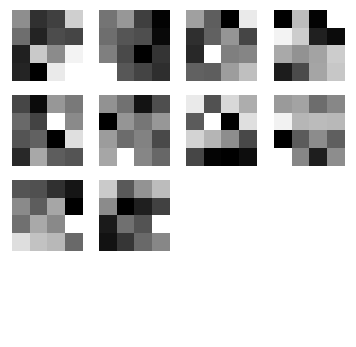

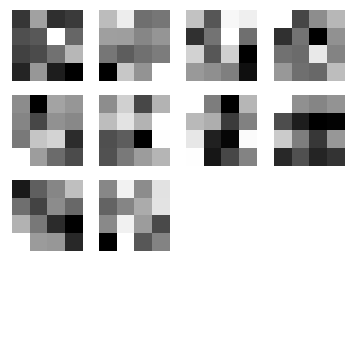

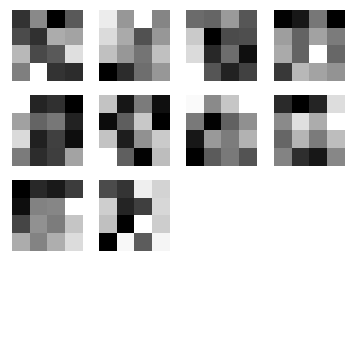

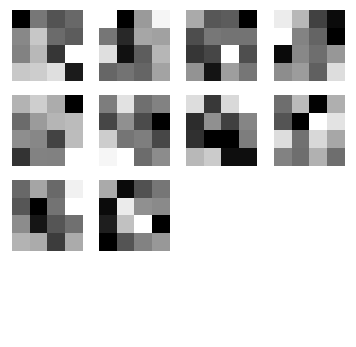

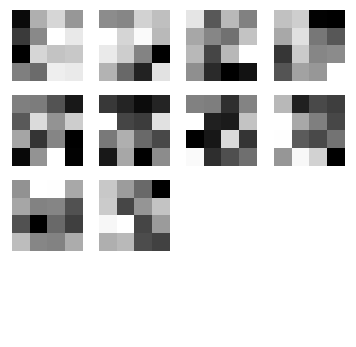

In [29]:
X = X_test[6].reshape(-1, 1, 28, 28)

visualize.plot_occlusion(net0, X, target=[1])
visualize.plot_conv_activity(net0.layers_['conv2d3'], X)
visualize.plot_conv_weights(layer=net0.layers_[3])